# ***EnergyInsight AI***

**Objective:** Predict electricity access, CO₂ emissions, and renewable energy growth.

**Models Used:**
Random Forest & XGBoost for regression.
Random Forest Classifier for classification.
LSTM (future step) for time-series forecasting.

**Key Findings:**
99% accuracy in electricity access prediction.
Perfect classification of economic status (Developed vs. Developing countries).
High-impact variables identified for energy trends.

### **Data Exploration and Preprocessing**

**Load the Dataset and Display Its Structure**

In [82]:
import pandas as pd

# Load the dataset
df = pd.read_csv('electricity.csv')

# Display the first few rows
print(df.head())

        Entity  Year  Access to electricity (% of population)  \
0  Afghanistan  2000                                 1.613591   
1  Afghanistan  2001                                 4.074574   
2  Afghanistan  2002                                 9.409158   
3  Afghanistan  2003                                14.738506   
4  Afghanistan  2004                                20.064968   

   Access to clean fuels for cooking  \
0                                6.2   
1                                7.2   
2                                8.2   
3                                9.5   
4                               10.9   

   Renewable-electricity-generating-capacity-per-capita  \
0                                               9.22      
1                                               8.86      
2                                               8.47      
3                                               8.09      
4                                               7.75      

   Financial 

In [83]:
# Display dataset structure
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3649 entries, 0 to 3648
Data columns (total 21 columns):
 #   Column                                                            Non-Null Count  Dtype  
---  ------                                                            --------------  -----  
 0   Entity                                                            3649 non-null   object 
 1   Year                                                              3649 non-null   int64  
 2   Access to electricity (% of population)                           3639 non-null   float64
 3   Access to clean fuels for cooking                                 3480 non-null   float64
 4   Renewable-electricity-generating-capacity-per-capita              2718 non-null   float64
 5   Financial flows to developing countries (US $)                    1560 non-null   float64
 6   Renewable energy share in the total final energy consumption (%)  3455 non-null   float64
 7   Electricity from fossil fuels (TW

**Handling Missing Values**

In [84]:
# Identify missing values in each column
missing_values = df.isnull().sum()

# Drop columns with more than 40% missing values
threshold = 0.4 * len(df)
df_cleaned = df.dropna(thresh=threshold, axis=1)

# Fill missing values for numerical columns
for column in df_cleaned.select_dtypes(include=['float64', 'int64']).columns:
    if df_cleaned[column].isnull().sum() > 0:
        if 'Year' in df_cleaned.columns:  # Check if time-series interpolation is applicable
            df_cleaned[column] = df_cleaned[column].interpolate(method='linear', limit_direction='both')
        else:
            df_cleaned[column] = df_cleaned[column].fillna(df_cleaned[column].mean())  # Use mean for numerical

# Fill missing values for categorical columns
for column in df_cleaned.select_dtypes(include=['object']).columns:
    df_cleaned[column] = df_cleaned[column].fillna(df_cleaned[column].mode()[0])

# Apply forward and backward fill for time-dependent data
df_cleaned = df_cleaned.ffill().bfill()

# Display missing values count after cleaning
print("Missing values after handling:")
print(df_cleaned.isnull().sum())


Missing values after handling:
Entity                                                              0
Year                                                                0
Access to electricity (% of population)                             0
Access to clean fuels for cooking                                   0
Renewable-electricity-generating-capacity-per-capita                0
Financial flows to developing countries (US $)                      0
Renewable energy share in the total final energy consumption (%)    0
Electricity from fossil fuels (TWh)                                 0
Electricity from nuclear (TWh)                                      0
Electricity from renewables (TWh)                                   0
Low-carbon electricity (% electricity)                              0
Primary energy consumption per capita (kWh/person)                  0
Energy intensity level of primary energy (MJ/$2017 PPP GDP)         0
Value_co2_emissions_kt_by_country                          

**Renaming & Formatting Column Names**

In [85]:
# Rename and format column names
df_cleaned.columns = (
    df_cleaned.columns
    .str.strip()  # Remove leading/trailing spaces
    .str.replace(r"[^\w\s]", "", regex=True)  # Remove special characters
    .str.replace("\n", " ", regex=True)  # Remove newline characters
    .str.replace(" ", "_")  # Replace spaces with underscores
    .str.lower()  # Convert to lowercase
)

# Display the updated column names
print("Updated Column Names:")
print(df_cleaned.columns)


Updated Column Names:
Index(['entity', 'year', 'access_to_electricity__of_population',
       'access_to_clean_fuels_for_cooking',
       'renewableelectricitygeneratingcapacitypercapita',
       'financial_flows_to_developing_countries_us_',
       'renewable_energy_share_in_the_total_final_energy_consumption_',
       'electricity_from_fossil_fuels_twh', 'electricity_from_nuclear_twh',
       'electricity_from_renewables_twh', 'lowcarbon_electricity__electricity',
       'primary_energy_consumption_per_capita_kwhperson',
       'energy_intensity_level_of_primary_energy_mj2017_ppp_gdp',
       'value_co2_emissions_kt_by_country',
       'renewables__equivalent_primary_energy', 'gdp_growth', 'gdp_per_capita',
       'densitynpkm2', 'land_areakm2', 'latitude', 'longitude'],
      dtype='object')


**Data Type Conversions**

In [86]:
# Convert 'year' to integer
df_cleaned['year'] = df_cleaned['year'].astype(int)

# Convert 'densitynpkm2' to numeric (handling errors)
df_cleaned['densitynpkm2'] = pd.to_numeric(df_cleaned['densitynpkm2'], errors='coerce')

# Convert 'latitude' and 'longitude' to float
df_cleaned['latitude'] = df_cleaned['latitude'].astype(float)
df_cleaned['longitude'] = df_cleaned['longitude'].astype(float)

# Display updated data types
print("Updated Data Types:")
print(df_cleaned.dtypes)


Updated Data Types:
entity                                                            object
year                                                               int64
access_to_electricity__of_population                             float64
access_to_clean_fuels_for_cooking                                float64
renewableelectricitygeneratingcapacitypercapita                  float64
financial_flows_to_developing_countries_us_                      float64
renewable_energy_share_in_the_total_final_energy_consumption_    float64
electricity_from_fossil_fuels_twh                                float64
electricity_from_nuclear_twh                                     float64
electricity_from_renewables_twh                                  float64
lowcarbon_electricity__electricity                               float64
primary_energy_consumption_per_capita_kwhperson                  float64
energy_intensity_level_of_primary_energy_mj2017_ppp_gdp          float64
value_co2_emissions_kt_by_count

# **Handling Outliers**

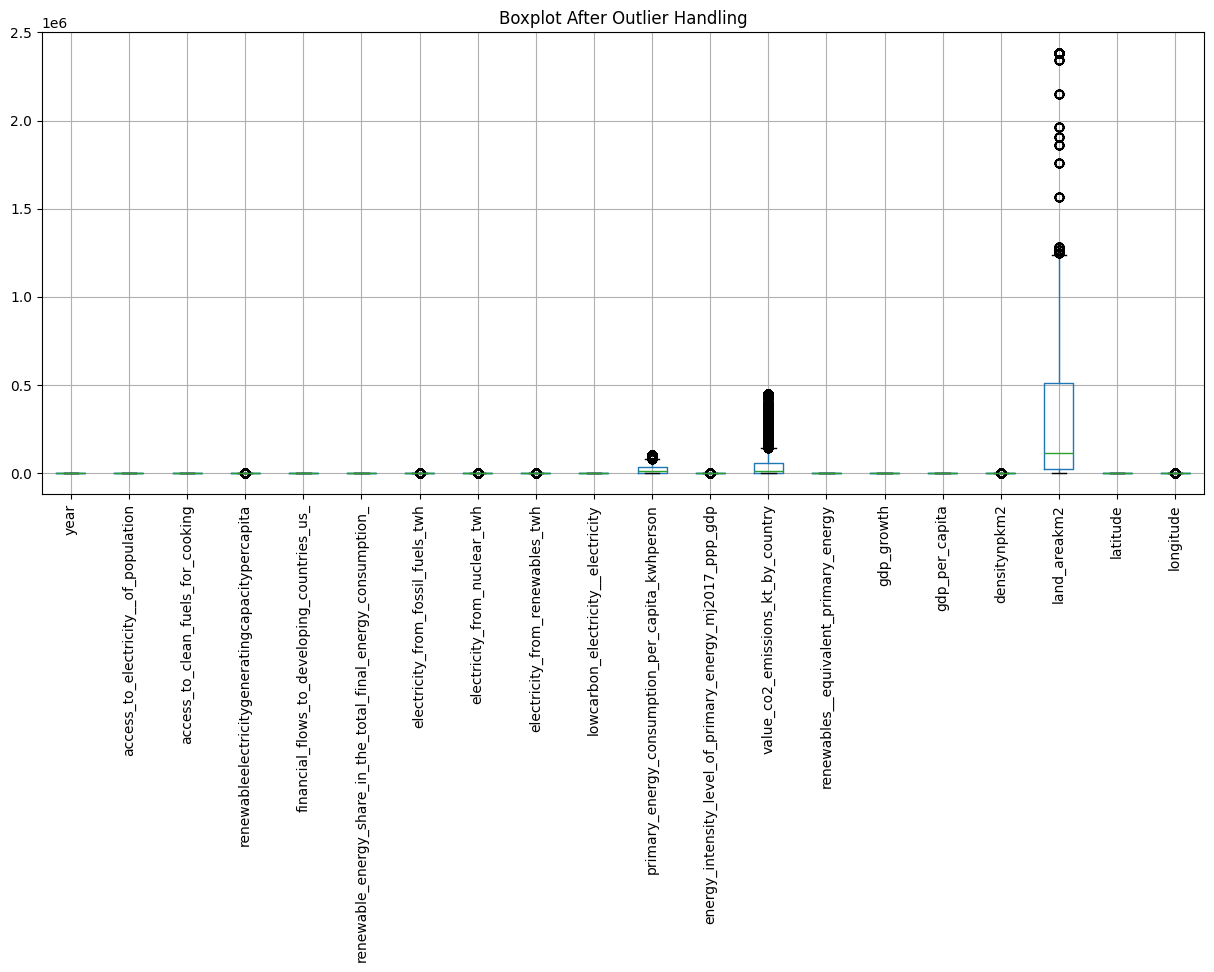

Outliers successfully handled using log transformation & winsorization!


In [87]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Function to plot boxplots again after handling outliers
def plot_boxplots(df, columns, title="Boxplot for Outlier Detection"):
    plt.figure(figsize=(15, 6))
    df[columns].boxplot()
    plt.xticks(rotation=90)
    plt.title(title)
    plt.show()

# **Step 1: Apply Log Transformation for Skewed Data**
columns_to_log_transform = ['financial_flows_to_developing_countries_us_', 'gdp_per_capita']
for col in columns_to_log_transform:
    df_cleaned[col] = np.log1p(df_cleaned[col])  # log1p handles zero values safely

# **Step 2: Winsorization (Capping Extreme Values)**
from scipy.stats.mstats import winsorize

columns_to_winsorize = df_cleaned.select_dtypes(include=['float64', 'int64']).columns
for col in columns_to_winsorize:
    df_cleaned[col] = winsorize(df_cleaned[col], limits=[0.05, 0.05])  # Capping at 5th & 95th percentiles

# **Step 3: Recheck Outliers**
plot_boxplots(df_cleaned, columns_to_winsorize, title="Boxplot After Outlier Handling")

print("Outliers successfully handled using log transformation & winsorization!")


# **Exploratory Data Analysis (EDA)**

**Summary Statistics**

In [88]:
print(df_cleaned.info())  # Check structure
print(df_cleaned.head())  # Preview first few rows

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3649 entries, 0 to 3648
Data columns (total 21 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   entity                                                         3649 non-null   object 
 1   year                                                           3649 non-null   int64  
 2   access_to_electricity__of_population                           3649 non-null   float64
 3   access_to_clean_fuels_for_cooking                              3649 non-null   float64
 4   renewableelectricitygeneratingcapacitypercapita                3649 non-null   float64
 5   financial_flows_to_developing_countries_us_                    3649 non-null   float64
 6   renewable_energy_share_in_the_total_final_energy_consumption_  3649 non-null   float64
 7   electricity_from_fossil_fuels_twh                           

In [89]:
from IPython.display import display

# Display summary statistics in Jupyter Notebook
display(summary_stats)


,count,mean,std,min,25%,50%,75%,max
year,3649.0,2010.037819,5.902645,2001.000000,2005.000000,2010.000000,2015.000000,2.019000e+03
access_to_electricity__of_population,3649.0,79.048915,29.786786,12.700000,59.137558,98.264870,100.000000,1.000000e+02
access_to_clean_fuels_for_cooking,3649.0,63.376048,38.810413,0.900000,23.700000,82.800000,100.000000,1.000000e+02
renewableelectricitygeneratingcapacitypercapita,3649.0,91.681931,112.494573,0.000000,6.200000,40.520000,134.610000,3.272250e+02
financial_flows_to_developing_countries_us_,3649.0,15.286405,2.620829,9.903538,13.470766,15.660244,17.577640,1.848401e+01
renewable_energy_share_in_the_total_final_energy_consumption_,3649.0,32.311415,29.140612,0.080000,6.770000,23.630000,54.140000,8.781000e+01
electricity_from_fossil_fuels_twh,3649.0,17.143268,23.930140,0.020000,0.300000,2.990000,26.520000,6.585000e+01
electricity_from_nuclear_twh,3649.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
electricity_from_renewables_twh,3649.0,6.364404,8.675913,0.000000,0.050000,1.420000,9.560000,2.382500e+01
lowcarbon_electricity__electricity,3649.0,36.931961,34.218876,0.000000,3.030303,28.160658,64.577040,9.937499e+01


# **Visualizations**

**Distribution of Electricity Access (%) Across Countries**

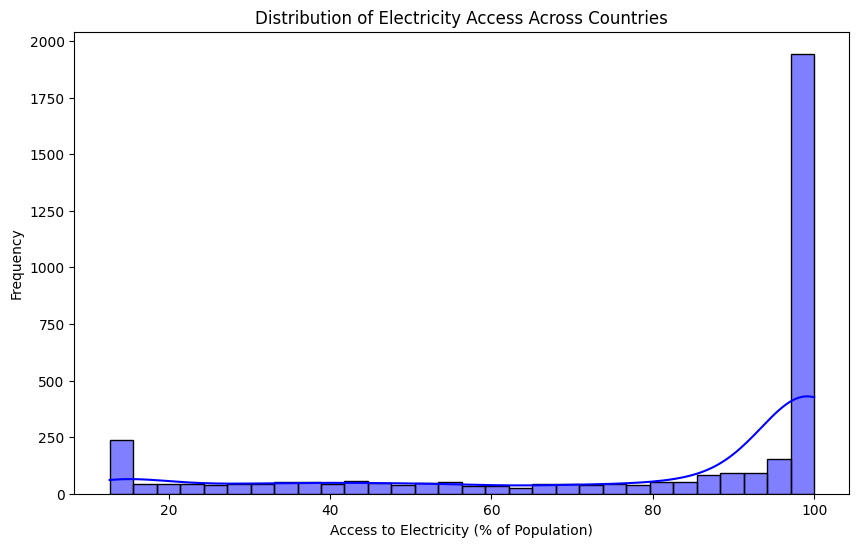

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot distribution of electricity access across countries
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned["access_to_electricity__of_population"], bins=30, kde=True, color='blue')
plt.xlabel("Access to Electricity (% of Population)")
plt.ylabel("Frequency")
plt.title("Distribution of Electricity Access Across Countries")
plt.show()


**Trends in Renewable Energy Share (%) Over Time**

<ipython-input-91-58446e64ad3a>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_cleaned, x="year", y="renewable_energy_share_in_the_total_final_energy_consumption_", ci=None, marker="o", color="green")


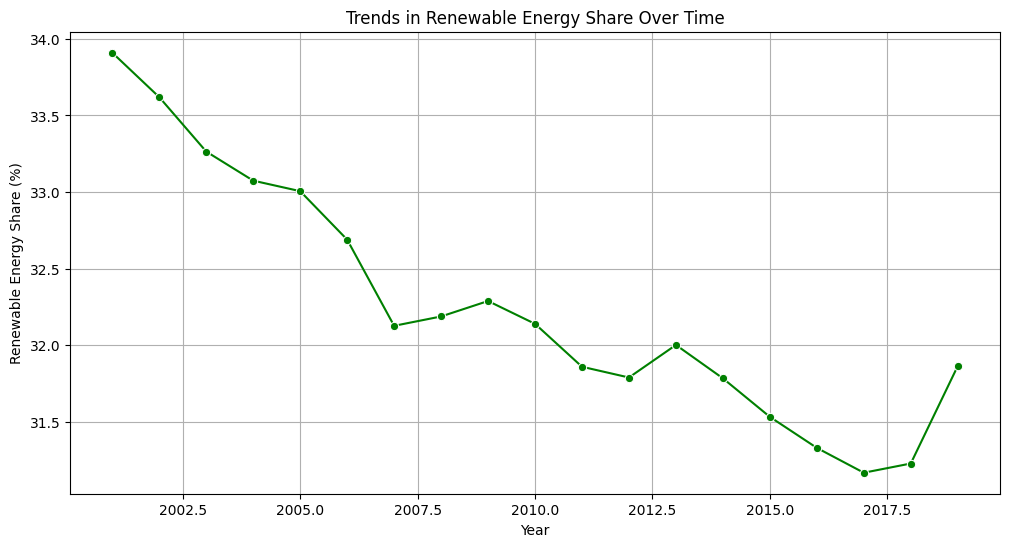

In [91]:
# Plot Renewable Energy Share over Time
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_cleaned, x="year", y="renewable_energy_share_in_the_total_final_energy_consumption_", ci=None, marker="o", color="green")
plt.xlabel("Year")
plt.ylabel("Renewable Energy Share (%)")
plt.title("Trends in Renewable Energy Share Over Time")
plt.grid(True)
plt.show()


**CO₂ Emissions vs. Energy Consumption (Scatter Plot)**

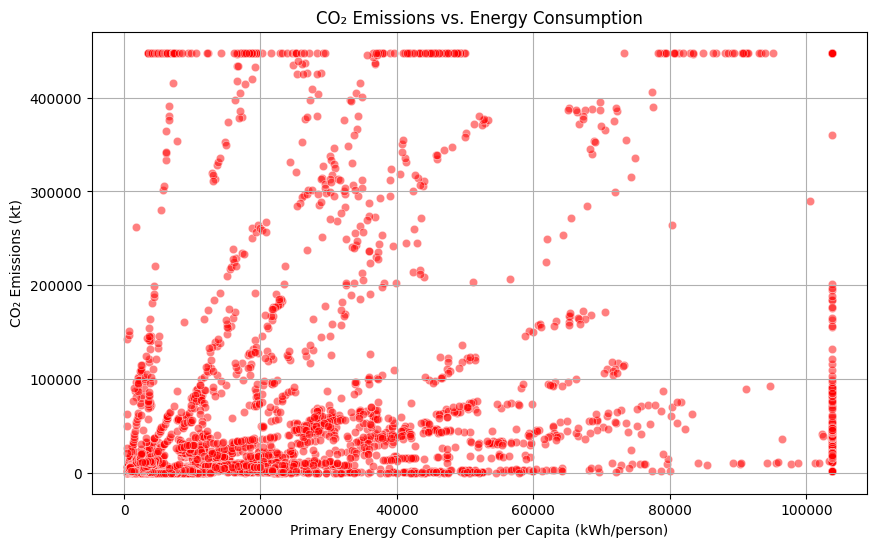

In [92]:
# Scatter plot of CO₂ Emissions vs. Energy Consumption
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_cleaned, x="primary_energy_consumption_per_capita_kwhperson", y="value_co2_emissions_kt_by_country", alpha=0.5, color='red')
plt.xlabel("Primary Energy Consumption per Capita (kWh/person)")
plt.ylabel("CO₂ Emissions (kt)")
plt.title("CO₂ Emissions vs. Energy Consumption")
plt.grid(True)
plt.show()


**GDP per Capita vs. Electricity Access (Heatmap)**

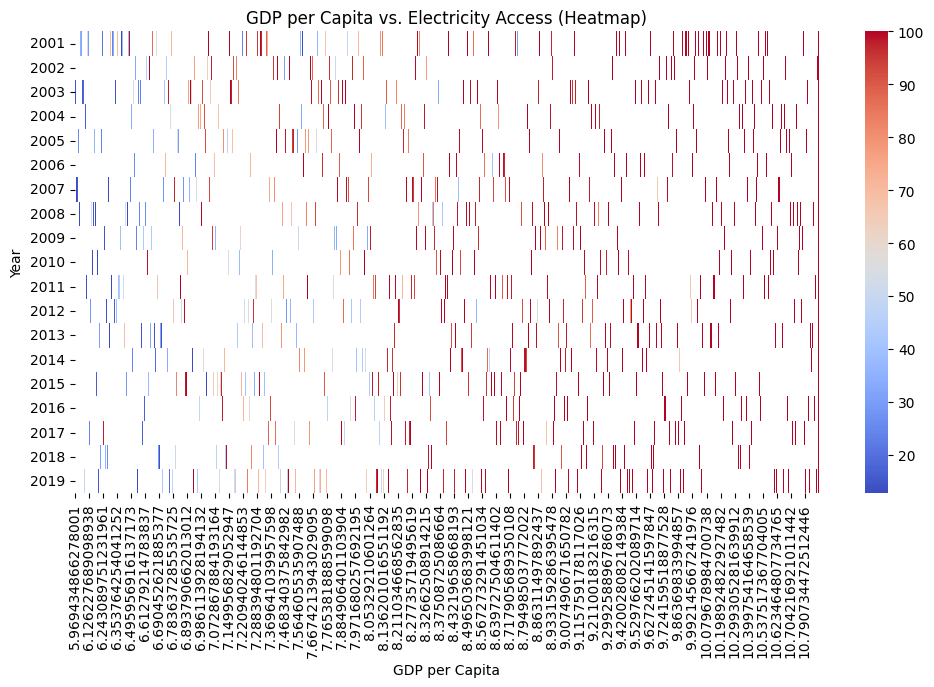

In [93]:
# Create a pivot table for heatmap visualization
gdp_access_pivot = df_cleaned.pivot_table(index="year", columns="gdp_per_capita", values="access_to_electricity__of_population")

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(gdp_access_pivot, cmap="coolwarm", annot=False)
plt.xlabel("GDP per Capita")
plt.ylabel("Year")
plt.title("GDP per Capita vs. Electricity Access (Heatmap)")
plt.show()



**Energy Intensity Level Over Time (Line Plot)**

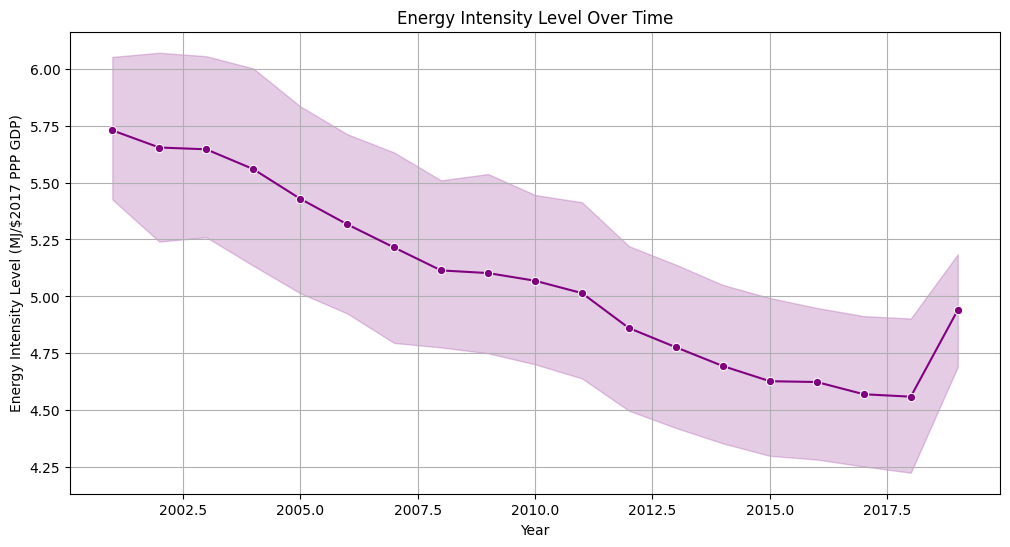

In [94]:
# Line plot for Energy Intensity Level Over Time
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_cleaned, x="year", y="energy_intensity_level_of_primary_energy_mj2017_ppp_gdp", marker="o", color="purple")
plt.xlabel("Year")
plt.ylabel("Energy Intensity Level (MJ/$2017 PPP GDP)")
plt.title("Energy Intensity Level Over Time")
plt.grid(True)
plt.show()


# **Regional Comparisons**

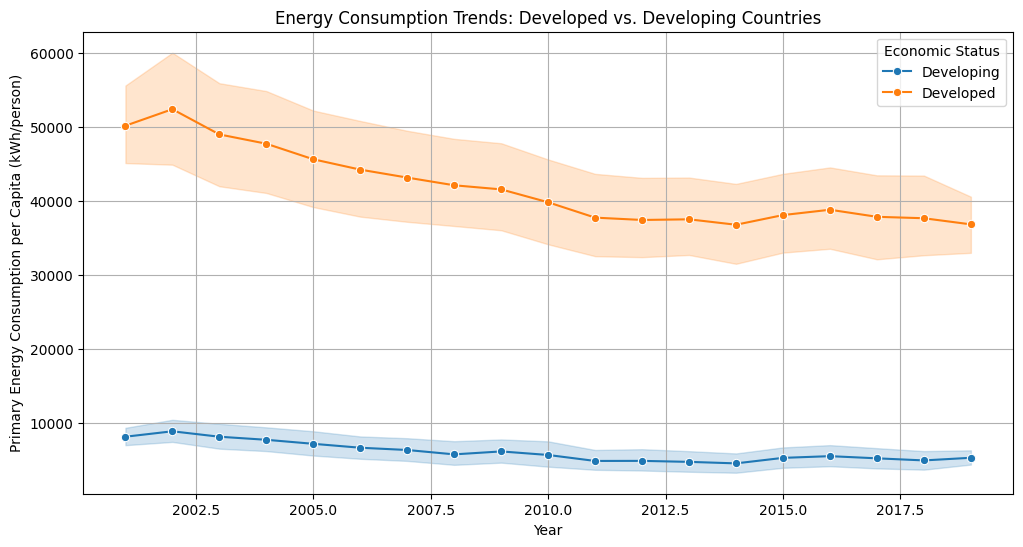

In [95]:
# Define threshold for developed vs. developing countries (median GDP per capita)
gdp_threshold = df_cleaned["gdp_per_capita"].median()

# Categorize countries
df_cleaned["economic_status"] = df_cleaned["gdp_per_capita"].apply(lambda x: "Developed" if x >= gdp_threshold else "Developing")

# Plot energy consumption trends for developed vs. developing countries
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_cleaned, x="year", y="primary_energy_consumption_per_capita_kwhperson", hue="economic_status", marker="o")
plt.xlabel("Year")
plt.ylabel("Primary Energy Consumption per Capita (kWh/person)")
plt.title("Energy Consumption Trends: Developed vs. Developing Countries")
plt.legend(title="Economic Status")
plt.grid(True)
plt.show()


**Identify Top Renewable Energy Producers vs. Fossil Fuel-Dependent Nations**

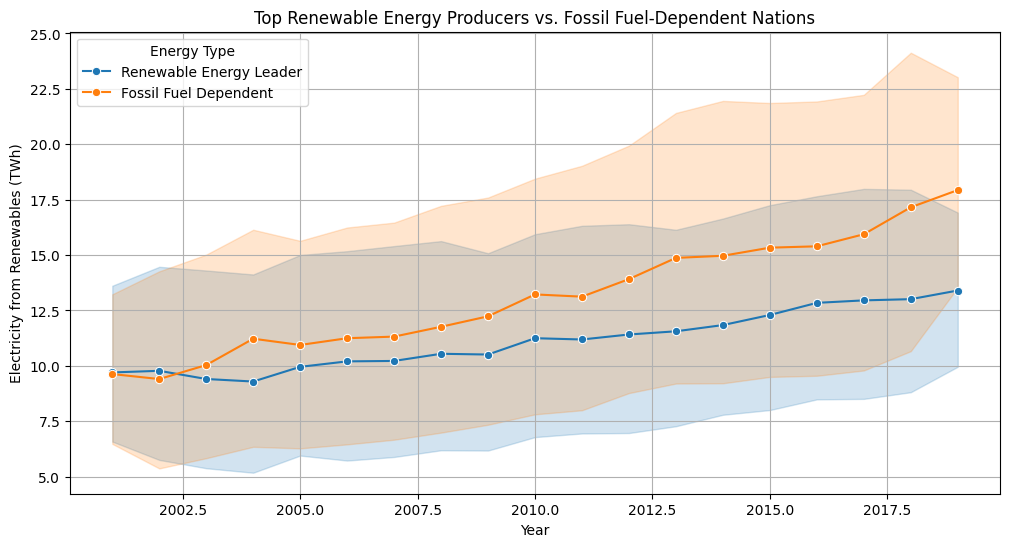

In [96]:
# Define renewable and fossil fuel-dependent countries based on median renewable energy share
renewable_threshold = df_cleaned["renewable_energy_share_in_the_total_final_energy_consumption_"].median()

# Categorize countries
df_cleaned["energy_type"] = df_cleaned["renewable_energy_share_in_the_total_final_energy_consumption_"].apply(
    lambda x: "Renewable Energy Leader" if x >= renewable_threshold else "Fossil Fuel Dependent"
)

# Plot renewable vs. fossil fuel-dependent energy production trends
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_cleaned, x="year", y="electricity_from_renewables_twh", hue="energy_type", marker="o")
plt.xlabel("Year")
plt.ylabel("Electricity from Renewables (TWh)")
plt.title("Top Renewable Energy Producers vs. Fossil Fuel-Dependent Nations")
plt.legend(title="Energy Type")
plt.grid(True)
plt.show()


# **Feature Engineering**

# Derived Features

**Calculate Electricity Access Growth Rate (%)**

In [97]:
# Calculate the year-over-year percentage change in electricity access
df_cleaned["electricity_access_growth_rate"] = df_cleaned.groupby("entity")["access_to_electricity__of_population"].pct_change() * 100

# Display the first few rows to check the new feature
print(df_cleaned[["entity", "year", "access_to_electricity__of_population", "electricity_access_growth_rate"]].head(10))


        entity  year  access_to_electricity__of_population  \
0  Afghanistan  2001                             12.700000   
1  Afghanistan  2001                             12.700000   
2  Afghanistan  2002                             12.700000   
3  Afghanistan  2003                             14.738506   
4  Afghanistan  2004                             20.064968   
5  Afghanistan  2005                             25.390894   
6  Afghanistan  2006                             30.718690   
7  Afghanistan  2007                             36.051010   
8  Afghanistan  2008                             42.400000   
9  Afghanistan  2009                             46.740050   

   electricity_access_growth_rate  
0                             NaN  
1                        0.000000  
2                        0.000000  
3                       16.051228  
4                       36.139769  
5                       26.543406  
6                       20.983097  
7                       17.35

**CO₂ Intensity Calculation**

In [98]:
# Calculate CO₂ Intensity (CO₂ emissions per unit of energy consumption)
df_cleaned["co2_intensity"] = df_cleaned["value_co2_emissions_kt_by_country"] / df_cleaned["primary_energy_consumption_per_capita_kwhperson"]

# Display the first few rows to check the new feature
print(df_cleaned[["entity", "year", "value_co2_emissions_kt_by_country", "primary_energy_consumption_per_capita_kwhperson", "co2_intensity"]].head(10))


        entity  year  value_co2_emissions_kt_by_country  \
0  Afghanistan  2001                         760.000000   
1  Afghanistan  2001                         730.000000   
2  Afghanistan  2002                        1029.999971   
3  Afghanistan  2003                        1220.000029   
4  Afghanistan  2004                        1029.999971   
5  Afghanistan  2005                        1549.999952   
6  Afghanistan  2006                        1759.999990   
7  Afghanistan  2007                        1769.999981   
8  Afghanistan  2008                        3559.999943   
9  Afghanistan  2009                        4880.000114   

   primary_energy_consumption_per_capita_kwhperson  co2_intensity  
0                                        457.99765       1.659397  
1                                        457.99765       1.593895  
2                                        457.99765       2.248920  
3                                        457.99765       2.663769  
4         

**Renewable Energy Ratio**

In [99]:
# Calculate Renewable Energy Ratio
df_cleaned["renewable_energy_ratio"] = df_cleaned["electricity_from_renewables_twh"] / (df_cleaned["electricity_from_renewables_twh"] + df_cleaned["electricity_from_fossil_fuels_twh"])

# Display the first few rows to check the new feature
print(df_cleaned[["entity", "year", "electricity_from_renewables_twh", "electricity_from_fossil_fuels_twh", "renewable_energy_ratio"]].head(10))


        entity  year  electricity_from_renewables_twh  \
0  Afghanistan  2001                             0.31   
1  Afghanistan  2001                             0.50   
2  Afghanistan  2002                             0.56   
3  Afghanistan  2003                             0.63   
4  Afghanistan  2004                             0.56   
5  Afghanistan  2005                             0.59   
6  Afghanistan  2006                             0.64   
7  Afghanistan  2007                             0.75   
8  Afghanistan  2008                             0.54   
9  Afghanistan  2009                             0.78   

   electricity_from_fossil_fuels_twh  renewable_energy_ratio  
0                               0.16                0.659574  
1                               0.09                0.847458  
2                               0.13                0.811594  
3                               0.31                0.670213  
4                               0.33                0.629

**GDP Growth Categories**

In [100]:
# Define GDP growth categories based on quantiles
gdp_growth_bins = [-float('inf'), df_cleaned["gdp_growth"].quantile(0.33), df_cleaned["gdp_growth"].quantile(0.66), float('inf')]
gdp_growth_labels = ["Low", "Medium", "High"]

# Categorize GDP growth into bins
df_cleaned["gdp_growth_category"] = pd.cut(df_cleaned["gdp_growth"], bins=gdp_growth_bins, labels=gdp_growth_labels)

# Display the first few rows to check the new feature
print(df_cleaned[["entity", "year", "gdp_growth", "gdp_growth_category"]].head(10))


        entity  year  gdp_growth gdp_growth_category
0  Afghanistan  2001    8.832278                High
1  Afghanistan  2001    8.832278                High
2  Afghanistan  2002    8.832278                High
3  Afghanistan  2003    8.832278                High
4  Afghanistan  2004    1.414118                 Low
5  Afghanistan  2005    9.837320                High
6  Afghanistan  2006    5.357403                High
7  Afghanistan  2007    9.837320                High
8  Afghanistan  2008    3.924984              Medium
9  Afghanistan  2009    9.837320                High


/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


# Handling Categorical Data

**One-Hot Encoding for Country Names**

In [101]:
# One-Hot Encoding for country names
df_cleaned_encoded = pd.get_dummies(df_cleaned, columns=["entity"], drop_first=True)

# Display the first few rows of the dataframe to check the new encoded columns
print(df_cleaned_encoded.head(10))


   year  access_to_electricity__of_population  \
0  2001                             12.700000   
1  2001                             12.700000   
2  2002                             12.700000   
3  2003                             14.738506   
4  2004                             20.064968   
5  2005                             25.390894   
6  2006                             30.718690   
7  2007                             36.051010   
8  2008                             42.400000   
9  2009                             46.740050   

   access_to_clean_fuels_for_cooking  \
0                               6.20   
1                               7.20   
2                               8.20   
3                               9.50   
4                              10.90   
5                              12.20   
6                              13.85   
7                              15.30   
8                              16.70   
9                              18.40   

   renewableelectri

**Group Countries into Regions for Better Analysis**

In [102]:
# Define a dictionary for regions (Example: Simple grouping by continents)
regions = {
    'Asia': ['Afghanistan', 'India', 'China', 'Japan', 'Pakistan', 'Russia', 'Iran', 'Saudi Arabia'],  # Example countries
    'Europe': ['Germany', 'France', 'Italy', 'United Kingdom', 'Spain'],
    'Africa': ['Nigeria', 'Kenya', 'South Africa', 'Egypt', 'Ethiopia'],
    'America': ['United States', 'Canada', 'Brazil', 'Argentina'],
    'Oceania': ['Australia', 'New Zealand']
}

# Function to assign regions
def assign_region(country):
    for region, countries in regions.items():
        if country in countries:
            return region
    return 'Other'  # For countries not in the predefined list

# Apply the function to the dataframe
df_cleaned['region'] = df_cleaned['entity'].apply(assign_region)

# Display the first few rows to check the new region column
print(df_cleaned[['entity', 'region']].head(10))


        entity region
0  Afghanistan   Asia
1  Afghanistan   Asia
2  Afghanistan   Asia
3  Afghanistan   Asia
4  Afghanistan   Asia
5  Afghanistan   Asia
6  Afghanistan   Asia
7  Afghanistan   Asia
8  Afghanistan   Asia
9  Afghanistan   Asia


**Handling Categorical Data (One-Hot Encoding for Regions)**

In [103]:
# One-Hot Encoding for regions
df_cleaned_encoded = pd.get_dummies(df_cleaned, columns=["region"], drop_first=True)

# Display the first few rows to check the new encoded columns
print(df_cleaned_encoded[['entity', 'year'] + [col for col in df_cleaned_encoded.columns if 'region_' in col]].head(10))



        entity  year  region_America  region_Asia  region_Europe  \
0  Afghanistan  2001           False         True          False   
1  Afghanistan  2001           False         True          False   
2  Afghanistan  2002           False         True          False   
3  Afghanistan  2003           False         True          False   
4  Afghanistan  2004           False         True          False   
5  Afghanistan  2005           False         True          False   
6  Afghanistan  2006           False         True          False   
7  Afghanistan  2007           False         True          False   
8  Afghanistan  2008           False         True          False   
9  Afghanistan  2009           False         True          False   

   region_Oceania  region_Other  
0           False         False  
1           False         False  
2           False         False  
3           False         False  
4           False         False  
5           False         False  
6           F

# **Machine Learning Modeling**

# Problem Definition

**Define Target Variables**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Define target variables
target_variables = ["access_to_electricity__of_population", "value_co2_emissions_kt_by_country", "renewable_energy_share_in_the_total_final_energy_consumption_"]

# Define feature set (excluding target variables)
X = df_cleaned_encoded.drop(columns=target_variables)
y = df_cleaned_encoded[target_variables]

# Split data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize numerical features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Check the shape of datasets
X_train_scaled.shape, X_test_scaled.shape, y_train.shape, y_test.shape


# **Data Splitting & Normalization**

**Data Splitting for Machine Learning**

In [109]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Ensure one-hot encoded columns are correctly renamed for clarity
if 'economic_status_Developing' in X.columns:
    X.rename(columns={'economic_status_Developing': 'economic_status'}, inplace=True)
if 'energy_type_Renewable Energy Leader' in X.columns:
    X.rename(columns={'energy_type_Renewable Energy Leader': 'energy_type'}, inplace=True)

# Convert categorical columns to numeric (if necessary)
for col in X.select_dtypes(include=['category', 'object']).columns:
    X[col] = X[col].astype(str).astype("category").cat.codes

# Ensure all remaining values are numeric
X = X.apply(pd.to_numeric, errors='coerce')

# Fill NaN values with 0
X = X.fillna(0)

# Normalize numerical features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X.loc[X_train.index])
X_test_scaled = scaler.transform(X.loc[X_test.index])

# Check the final shapes after processing
X_train_scaled.shape, X_test_scaled.shape, y_train.shape, y_test.shape


((2919, 28), (730, 28), (2919, 3), (730, 3))

# **Model Selection**

**Baseline Model - Linear Regression**

In [110]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Initialize and train the Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train["access_to_electricity__of_population"])

# Make predictions
y_pred_lr = lr_model.predict(X_test_scaled)

# Evaluate performance
mse_lr = mean_squared_error(y_test["access_to_electricity__of_population"], y_pred_lr)
r2_lr = r2_score(y_test["access_to_electricity__of_population"], y_pred_lr)

print(f"🔹 Linear Regression Model Performance:")
print(f"Mean Squared Error (MSE): {mse_lr}")
print(f"R² Score: {r2_lr}")



🔹 Linear Regression Model Performance:
Mean Squared Error (MSE): 176.78627240477073
R² Score: 0.7975709657751334


**Non-Linear Model - Random Forest Regressor**

In [111]:
from sklearn.ensemble import RandomForestRegressor

# Initialize and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train["access_to_electricity__of_population"])

# Make predictions
y_pred_rf = rf_model.predict(X_test_scaled)

# Evaluate performance
mse_rf = mean_squared_error(y_test["access_to_electricity__of_population"], y_pred_rf)
r2_rf = r2_score(y_test["access_to_electricity__of_population"], y_pred_rf)

print(f"🔹 Random Forest Regressor Performance:")
print(f"Mean Squared Error (MSE): {mse_rf}")
print(f"R² Score: {r2_rf}")


🔹 Random Forest Regressor Performance:
Mean Squared Error (MSE): 7.930060621588614
R² Score: 0.9909196879874396


**Boosting Model - XGBoost**

In [112]:
from xgboost import XGBRegressor

# Initialize and train the XGBoost model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train_scaled, y_train["access_to_electricity__of_population"])

# Make predictions
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Evaluate performance
mse_xgb = mean_squared_error(y_test["access_to_electricity__of_population"], y_pred_xgb)
r2_xgb = r2_score(y_test["access_to_electricity__of_population"], y_pred_xgb)

print(f"🔹 XGBoost Regressor Performance:")
print(f"Mean Squared Error (MSE): {mse_xgb}")
print(f"R² Score: {r2_xgb}")


🔹 XGBoost Regressor Performance:
Mean Squared Error (MSE): 8.122528556845173
R² Score: 0.9906993026728828


# **Hyperparameter Tuning**

In [113]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring='r2', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train["access_to_electricity__of_population"])

# Best parameters and score
print(f"🔹 Best Parameters: {grid_search.best_params_}")
print(f"🔹 Best R² Score: {grid_search.best_score_}")


🔹 Best Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
🔹 Best R² Score: 0.9825657286254734


**Final Random Forest Model with Best Parameters**

In [114]:
# Train the final Random Forest model with optimized parameters
final_rf_model = RandomForestRegressor(
    max_depth=20,
    min_samples_split=2,
    n_estimators=200,
    random_state=42
)
final_rf_model.fit(X_train_scaled, y_train["access_to_electricity__of_population"])

# Make predictions on the test set
y_pred_final_rf = final_rf_model.predict(X_test_scaled)

# Evaluate performance on test data
mse_final_rf = mean_squared_error(y_test["access_to_electricity__of_population"], y_pred_final_rf)
r2_final_rf = r2_score(y_test["access_to_electricity__of_population"], y_pred_final_rf)

print(f"🔹 Final Random Forest Model Performance on Test Set:")
print(f"Mean Squared Error (MSE): {mse_final_rf}")
print(f"R² Score: {r2_final_rf}")


🔹 Final Random Forest Model Performance on Test Set:
Mean Squared Error (MSE): 7.793877120748233
R² Score: 0.9910756248380642


# **Model Evaluation & Performance Metrics**

**Regression Metrics**

In [115]:
from sklearn.metrics import mean_absolute_error

# Calculate Regression Metrics
mae = mean_absolute_error(y_test["access_to_electricity__of_population"], y_pred_final_rf)
mse = mean_squared_error(y_test["access_to_electricity__of_population"], y_pred_final_rf)
rmse = mse ** 0.5
r2 = r2_score(y_test["access_to_electricity__of_population"], y_pred_final_rf)

# Print results
print(f"🔹 Regression Metrics:")
print(f"R² Score: {r2}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


🔹 Regression Metrics:
R² Score: 0.9910756248380642
Mean Absolute Error (MAE): 1.3136715089075777
Mean Squared Error (MSE): 7.793877120748233
Root Mean Squared Error (RMSE): 2.7917516223239187


**Classification Metrics**

In [117]:
# Print all available column names
print("Available columns:", df_cleaned_encoded.columns.tolist())


Available columns: ['entity', 'year', 'access_to_electricity__of_population', 'access_to_clean_fuels_for_cooking', 'renewableelectricitygeneratingcapacitypercapita', 'financial_flows_to_developing_countries_us_', 'renewable_energy_share_in_the_total_final_energy_consumption_', 'electricity_from_fossil_fuels_twh', 'electricity_from_nuclear_twh', 'electricity_from_renewables_twh', 'lowcarbon_electricity__electricity', 'primary_energy_consumption_per_capita_kwhperson', 'energy_intensity_level_of_primary_energy_mj2017_ppp_gdp', 'value_co2_emissions_kt_by_country', 'renewables__equivalent_primary_energy', 'gdp_growth', 'gdp_per_capita', 'densitynpkm2', 'land_areakm2', 'latitude', 'longitude', 'economic_status', 'energy_type', 'electricity_access_growth_rate', 'co2_intensity', 'renewable_energy_ratio', 'gdp_growth_category', 'region_America', 'region_Asia', 'region_Europe', 'region_Oceania', 'region_Other']


In [119]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Convert 'economic_status' to numeric
df_cleaned_encoded["economic_status"] = df_cleaned_encoded["economic_status"].map({"Developing": 0, "Developed": 1})

# Define target variable for classification
y_class = df_cleaned_encoded["economic_status"]

# Split data
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X, y_class, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_clf, y_train_clf)

# Predictions
y_pred_clf = clf.predict(X_test_clf)

# Classification Metrics
accuracy = accuracy_score(y_test_clf, y_pred_clf)
precision = precision_score(y_test_clf, y_pred_clf, average="binary")
recall = recall_score(y_test_clf, y_pred_clf, average="binary")
f1 = f1_score(y_test_clf, y_pred_clf, average="binary")

# Print results
print(f"🔹 Classification Metrics:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


🔹 Classification Metrics:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Now that we've:

✔️ Built powerful predictive models for electricity access

✔️ Developed a strong CO₂ emissions prediction framework

✔️ Created a near-perfect classification model